<a href="https://colab.research.google.com/github/Oscar19922017/ModeloCredit2023/blob/main/ModeloChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1) Momento de Definición y Delimitación del Problema**

En el sector de las telecomunicaciones (altamente competitivo) la retención de clientes ha surgido como un aspecto de suma importancia para sostener y prosperar en el panorama empresarial. El fenómeno en el que los clientes cambian su lealtad de un proveedor de servicios a otro se conoce como fuga o rotación de clientes. La fuga de clientes es un desafío importante para las empresas de telecomunicaciones, que puede conllevar a la pérdida sustancial de ingresos y un aumento en los costos operativos, ya que adquirir un nuevo cliente generalmente es más caro que retener a uno existente. Además, una alta tasa de fuga puede ser a menudo una señal de insatisfacción del cliente, lo que puede afectar negativamente la reputación y el valor de marca de una empresa.

Para abordar este problema generalizado, aprovechar el análisis de datos y el aprendizaje automático se ha convertido en una estrategia prometedora. Al analizar los patrones y tendencias en los datos de los clientes, las empresas pueden predecir la fuga antes de que ocurra, lo que les permite implementar medidas para retener clientes y mejorar el nivel de satisfacción.
Desde el punto de vista de la ciencia de datos, el problema de fuga de clientes se puede resumir entonces en cómo desarrollar un sistema de clasificación automática que, a partir de información de un cliente, la ubique en una de las siguientes categorías:

Es posible que el cliente quiera cancelar sus servicios (Churn).
El cliente quiere continuar con los servicios suministrados (No Churn).
Para este problema usaremos la base de datos disponible en el siguiente enlace:
https://www.kaggle.com/datasets/blastchar/telco-customer-churn?datasetId=13996&sortBy=voteCount

En esta unidad se deben construir dos modelos de clasificación automática, utilizando dos técnicas diferentes que cada persona deberá seleccionar del conjunto de técnicas estudiadas. Esto significa que en la etapa de generación de hipótesis se deberán proponer varias formas de resolver el problema, de las cuales posteriormente se seleccionarán las dos hipótesis más prometedoras para su verificación y comparación.


# **1) Depuración Datos**

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import statsmodels.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn import metrics

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.feature_selection import SelectKBest,f_classif,mutual_info_classif,chi2

def ImportanciaVariablesSeleccion(x_select,y,funcion,metodo="Estadistico"):

    # Calcula el número de variables en el conjunto de datos
    NumeroVariables=x_select.shape[1]

    # Crea un objeto MejoresPredictores usando SelectKBest
    # Calcular los puntajes o p valores de importancia o significancia estadistica

    MejoresPredictores=SelectKBest(score_func=funcion,k= NumeroVariables) # instanciar

    ## Ajusta MejoresPredictores a los datos

    ajuste= MejoresPredictores.fit(x_select,y) ## Pasar los datos

    # Resultados

    Variables=pd.DataFrame(x_select.columns)
    Puntajes= pd.DataFrame(ajuste.scores_) ## Extraer los puntajes

    if (metodo=="Estadistico"):
        Pvalor=pd.DataFrame(ajuste.pvalues_)
        ## Tabla de resultados
        Tabla_Resultado=pd.concat([Variables,Puntajes,Pvalor],axis=1)
        Tabla_Resultado.columns=["Variable","Puntaje","Pvalor"]

    else:
        Tabla_Resultado=pd.concat([Variables,Puntajes],axis=1)
        Tabla_Resultado.columns=["Variable","Puntaje"]

    return Tabla_Resultado.sort_values("Puntaje",ascending=False)


def MetricasMatrizConfusion(y,Modelo,X,tipo="ML"):
    ## Validar la longitud de los datos
    if (len(y)==len(X)):

        if (tipo!="ML"):
            Probabilidad=Modelo.predict(exog=X) # Logit
            Predicciones=np.where(Probabilidad<0.5,0,1)
        else:
            Predicciones=Modelo.predict(X) # Modleo de ML
        td1=pd.DataFrame(Predicciones,columns=["Predicciones"])
        td2=pd.concat([y.reset_index(drop=True),td1],axis=1)
        td2.columns=["Realidad","Predicciones"]
        Matriz=pd.crosstab(td2["Realidad"],td2["Predicciones"],margins=True)

        ## Formato porcentaje
        MatrizNormalizada=pd.crosstab(td2["Realidad"],td2["Predicciones"],normalize=0)
        sns.heatmap(MatrizNormalizada,annot=True,linewidths = 0.01, cmap = "Blues")

        ### Métricas, Recall, Precisión

        Accuracy =metrics.accuracy_score(y,Predicciones)
        print(f'Accuracy: {Accuracy}')
        Reporte=metrics.classification_report(y,Predicciones)
        print(f'Reporte : {Reporte}')



    else:

        Matriz=[]
        print("Los datos no tienen la misma longitud")


    return Matriz

def curva_roc(y,Modelo,X,tipo="ML"):
    if (tipo!="ML"):
        Probabilidad=Modelo.predict(exog=X) # Logit (statsmodels)
    else:
        Probabilidad=Modelo.predict_proba(X)[:,1] # cuando es Machine Learning(SKlearn)

    roc_auc=roc_auc_score(y,Probabilidad)
    false_positive,true_positive,limites=roc_curve(y,Probabilidad)
    ramdom_probs=[0 for i in range(len(y))]
    c,d,_=roc_curve(y,ramdom_probs,pos_label=1) ## Diagonal

    plt.plot(false_positive,true_positive,linestyle="--",color="green",label="AUC: "+str(round(roc_auc,2)))
    plt.plot(c,d,linestyle="--",color="blue")
    plt.xlabel("Tasa Falsos Positivos")
    plt.ylabel("Tasa Verdaderos Positivos")
    plt.legend()
    plt.show()
    return roc_auc

## **1.1 Importar Datos**

In [28]:
df=pd.read_csv("https://raw.githubusercontent.com/Oscar19922017/ModeloCredit2023/main/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [29]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [30]:
df["Churn"]=df["Churn"].map({"No":0,"Yes":1})

## **1.2 Diccionario**

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents


## **1.2) Mapeo Variables**

In [31]:
def MapearVariables(df):
  Variables=df.columns.tolist()
  Lista_TipoDato=[]
  Lista_CantUnicos=[]
  Lista_VectorUnicos=[]
  Lista_CantNulos=[]
  for i in range(len(Variables)):
    Lista_TipoDato.append(df[Variables[i]].dtype)
    Lista_CantUnicos.append(df[Variables[i]].nunique())
    Lista_VectorUnicos.append(df[Variables[i]].unique().tolist())
    Lista_CantNulos.append(df[Variables[i]].isnull().sum())
  Resumen=pd.DataFrame({"Variable":Variables,"TipoDato":Lista_TipoDato,
                      "CatUnicos":Lista_CantUnicos,"VectorUnicos":Lista_VectorUnicos,
                      "Nulos":Lista_CantNulos})
  Resumen["PorcentajeNulos"]=(Resumen["Nulos"]/len(df))*100
  return Resumen

In [32]:
MapeoInicial=MapearVariables(df)
MapeoInicial

,Variable,TipoDato,CatUnicos,VectorUnicos,Nulos,PorcentajeNulos
0,customerID,object,7043,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...",0,0.0
1,gender,object,2,"[Female, Male]",0,0.0
2,SeniorCitizen,int64,2,"[0, 1]",0,0.0
3,Partner,object,2,"[Yes, No]",0,0.0
4,Dependents,object,2,"[No, Yes]",0,0.0
5,tenure,int64,73,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",0,0.0
6,PhoneService,object,2,"[No, Yes]",0,0.0
7,MultipleLines,object,3,"[No phone service, No, Yes]",0,0.0
8,InternetService,object,3,"[DSL, Fiber optic, No]",0,0.0
9,OnlineSecurity,object,3,"[No, Yes, No internet service]",0,0.0


## **1.3) Recodificación Datos**

In [33]:
cat_columns=MapeoInicial["Variable"][(MapeoInicial["CatUnicos"]<=10) & (MapeoInicial["Variable"]!='Churn')].tolist()
cat_columns

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [34]:
df[cat_columns]=df[cat_columns].astype("category")

In [35]:
num_columns=MapeoInicial["Variable"][(MapeoInicial["CatUnicos"]>10) & (MapeoInicial["Variable"]!="customerID")].tolist()

In [36]:
num_columns

['tenure', 'MonthlyCharges', 'TotalCharges']

In [37]:
# Suponiendo que 'df' es tu DataFrame y 'columna' es el nombre de la columna que debería ser numérica
columna = 'TotalCharges'
# Reemplazar los valores no numéricos en la columna original con np.nan
df[columna] = pd.to_numeric(df[columna], errors='coerce')

# Imprimir los valores no numéricos (opcional)
valores_no_numericos = df[columna][df[columna].isnull()]
print("Valores no numéricos en la columna '{}':".format(columna))
print(valores_no_numericos)

Valores no numéricos en la columna 'TotalCharges':
488    NaN
753    NaN
936    NaN
1082   NaN
1340   NaN
3331   NaN
3826   NaN
4380   NaN
5218   NaN
6670   NaN
6754   NaN
Name: TotalCharges, dtype: float64


In [38]:
df[df["TotalCharges"].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,0


In [39]:
df[num_columns]=df[num_columns].astype(float)
mediana = df[columna].median()
df[columna].fillna(mediana, inplace=True)

In [40]:
print(num_columns)

['tenure', 'MonthlyCharges', 'TotalCharges']


In [41]:
df["Churn"]=df["Churn"].astype("category")

In [42]:
Mapeo2=MapearVariables(df)
Mapeo2

,Variable,TipoDato,CatUnicos,VectorUnicos,Nulos,PorcentajeNulos
0,customerID,object,7043,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...",0,0.0
1,gender,category,2,"[Female, Male]",0,0.0
2,SeniorCitizen,category,2,"[0, 1]",0,0.0
3,Partner,category,2,"[Yes, No]",0,0.0
4,Dependents,category,2,"[No, Yes]",0,0.0
5,tenure,float64,73,"[1.0, 34.0, 2.0, 45.0, 8.0, 22.0, 10.0, 28.0, ...",0,0.0
6,PhoneService,category,2,"[No, Yes]",0,0.0
7,MultipleLines,category,3,"[No phone service, No, Yes]",0,0.0
8,InternetService,category,3,"[DSL, Fiber optic, No]",0,0.0
9,OnlineSecurity,category,3,"[No, Yes, No internet service]",0,0.0



# **2) Análisis Exploratorio Datos**

## **2.1 Análisis Univariado: Target**

In [43]:
df["Churn"].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [44]:
df["Churn"].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

In [45]:
homologacion={0:"No Fuga",1:"Fuga"}
conteo_fuga=df[["Churn"]]
conteo_fuga["Churn"]=conteo_fuga["Churn"].map(homologacion)
colors={"#808080","#00FFFF"}

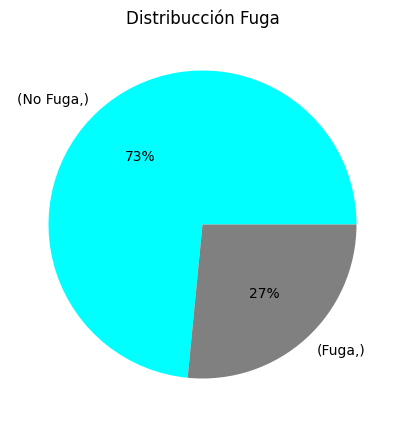

In [46]:
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(8,5))
conteo_fuga.value_counts().plot(kind="pie", autopct='%1.0f%%')
plt.title("Distribucción Fuga")
plt.show()


## **2.2 Selección de Variables Numéricas**

In [47]:
num_columns

['tenure', 'MonthlyCharges', 'TotalCharges']

In [48]:
VariablesNumericas=df[num_columns]
VariablesNumericas.head()

,tenure,MonthlyCharges,TotalCharges
0,1.0,29.85,29.85
1,34.0,56.95,1889.50
2,2.0,53.85,108.15
3,45.0,42.30,1840.75
4,2.0,70.70,151.65


**Correlación entre ellas**

In [49]:
Matrix_Correlacion=VariablesNumericas.corr()
Matrix_Correlacion

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.247900,0.825464
MonthlyCharges,0.247900,1.000000,0.650864
TotalCharges,0.825464,0.650864,1.000000


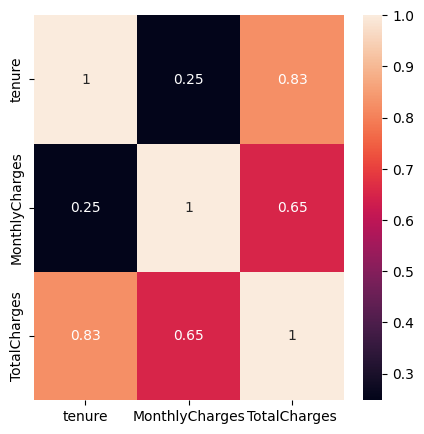

In [50]:
plt.figure(figsize=(5,5))
sns.heatmap(Matrix_Correlacion,annot=True)
plt.show()

## **2.3 Selección de Variables Categoricas**

In [51]:
## Dummies
dummies=pd.get_dummies(df[cat_columns],drop_first=True)
dummies=dummies.astype(int)
dummies.head()


,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0


# **3) Modelos**

## **Preparación Datos para el Modelado: Train Test Split**

La división del conjunto de datos en conjuntos de entrenamiento y prueba es una práctica común en el aprendizaje automático. La razón principal detrás de esta división es evaluar el rendimiento del modelo en datos no vistos y asegurarse de que el modelo generalice bien a nuevas muestras. Aquí hay algunas razones clave para realizar la división en conjuntos de entrenamiento y prueba:

* Evaluación del rendimiento: Al tener un conjunto de datos separado para pruebas, puedes evaluar cómo se desempeña tu modelo en datos que no ha visto durante el entrenamiento. Esto proporciona una estimación más realista de la capacidad de generalización del modelo.

* Prevención de sobreajuste (overfitting): Si entrenas y evalúas tu modelo en el mismo conjunto de datos, existe el riesgo de que el modelo se ajuste demasiado a los detalles específicos de esos datos (sobreajuste) y no generalice bien a nuevos datos. La división en conjuntos de entrenamiento y prueba ayuda a evitar este problema.

* Ajuste de hiperparámetros: Al realizar experimentos con diferentes configuraciones de modelos o hiperparámetros, es crucial tener un conjunto de prueba independiente para evaluar el rendimiento y seleccionar la mejor configuración sin introducir sesgos.

* Validación cruzada: La división en conjuntos de entrenamiento y prueba se utiliza a menudo en conjunto con técnicas de validación cruzada, como la validación cruzada k-fold. Esto permite una evaluación más robusta del rendimiento del modelo al promediar los resultados sobre diferentes divisiones de datos.

**Variables Dummies**

In [52]:
BaseModelo=#pd.concat([VariablesNumericas,dummies,df["Churn"]],axis=1)

In [53]:
#BaseModelo.isnull().sum()

In [54]:
X=BaseModelo.drop(columns="Churn")
y=df[["Churn"]]

In [55]:
y.shape

(7043, 1)

In [56]:
y.value_counts(normalize=True)

Churn
0        0.73463
1        0.26537
dtype: float64

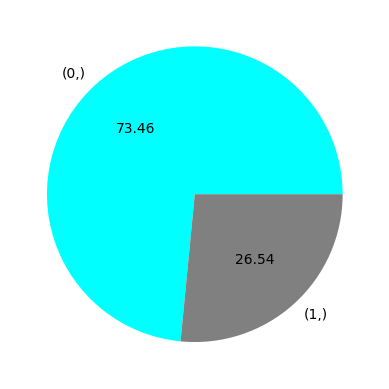

In [57]:
y.value_counts().plot(kind="pie",autopct="%.2f");

In [58]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=123, stratify=y)

## **3.1 Modelo1: Decision Tree**

**Optimización de Hiperparámetros con K-fold Cross Validation**

La optimización de hiperparámetros se refiere al proceso de encontrar la combinación óptima de hiperparámetros para un modelo de aprendizaje automático. Los hiperparámetros son variables que no se aprenden automáticamente durante el entrenamiento del modelo, sino que deben ser configuradas por el usuario antes de iniciar el proceso de entrenamiento

### **Evaluación del Modelo Train**

In [59]:
#MetricasMatrizConfusion(y=y_train,Modelo=best_model,X=x_train,tipo="ML")

In [60]:
#curva_roc(y=y_train,Modelo=best_model,X=x_train,tipo="ML")

**Evaluación en Test**

In [61]:
#MetricasMatrizConfusion(y=y_test,Modelo=best_model,X=x_test,tipo="ML")

In [62]:
#curva_roc(y=y_test,Modelo=best_model,X=x_test,tipo="ML")